# Assignment 2
## Roll Number : CS25MTECH02007
## Name : Rajat Maheshwari
<hr>

# Text Cleaning, and Model Building For Given DataSets

## 📝 Assignment Overview
In this assignment, I will:
1. **Implement** 4 different NLP classification models
2. **Clean and harmonize**  Given Data for model building
3. Perform **text-based Classification** on the cleaned data to extract insights.

# Install Modules

In [26]:
! pip install -r requirements.txt

# Necessary Imports

In [27]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import re
import urllib
import unicodedata
import urllib.parse
import nltk
import tensorflow as tf
from tensorflow.keras import layers, Model,callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

## NLTK Downloads

In [28]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       d

True

## NLTK Imports

In [29]:
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Text Cleaner Class

In [30]:
class TextCleaner:
    def __init__(self):
        # Initialize our regex detectives - these patterns help sniff out specfic data types
        self.json_pattern = re.compile(r'\{[^}]+\}', re.DOTALL)  # Catches JSON blobs like {key:val}
        self.math_pattern = re.compile(r'\$.*?\$', re.DOTALL)     # Finds mathy stuff between $$
        self.control_chars = re.compile(r"[\x00-\x09\x0B\x0C\x0E-\x1F\x7F-\x9F]")  # Weird control chars
        self.extra_newlines = re.compile(r'\n{9,}')  
        self.non_word_chars = re.compile(r"[^\w\s]")  # Non-word chars except spaces
        self.multi_space = re.compile(r" +")  # Squash multiple spacces

        # Set up NLP tools - lemmatizer for word roots, stopwords for common junk
        self.lemmatizer = WordNetLemmatizer()  # Makes words their base form (better -> good)
        self.stop_words = set(stopwords.words('english'))  # Common words like 'the', 'and'

    def _get_wordnet_pos(self, treebank_tag):
        # Helper to convert POS tags to wordnet format. Treebank tags are confusing TBH
        return {
            'J': wordnet.ADJ,  # Adjectives
            'V': wordnet.VERB,  # Verbs
            'R': wordnet.ADV  # Adverbs
        }.get(treebank_tag[0], wordnet.NOUN)  # Default to noun if no match

    def lemmatize_text(self, text, use_pos=True):
        """Turns words to their dictionary form. POS tagging helps accuracy but costs speed."""
        try:
            tokens = word_tokenize(text)  # Split text into words
            
            if use_pos:  
                pos_tags = nltk.pos_tag(tokens)  # Get grammar tags
                return ' '.join([
                    self.lemmatizer.lemmatize(word, self._get_wordnet_pos(tag))
                    for word, tag in pos_tags  # Process each word with its tag
                ])
            else:
                return ' '.join([self.lemmatizer.lemmatize(word) for word in tokens])
        except Exception as e:
            print(f"Lemmatization oopsie: {str(e)}")  # Log but don't crash
            return text  # Return original if things go south

    def remove_numbers(self, text):
        """Kicks out lonely numbers but keeps words with numbers (like B2B)"""
        return re.sub(r'\b\d+\b', '', text)  # \b means word boundary

    def clean_text(self, text):
        """Main scrubber - handles encoding weirdness and special characters"""
        try:
            text = self.control_chars.sub(" ", text)  # Remove control chars
            text = unicodedata.normalize("NFKD", text)  # Standardize fancy unicode
            text = text.replace("\u2022", "\n- ").replace("\xa0", " ")  # Bullets to dashes
            text = self.non_word_chars.sub(" ", text)  # Replace punctuation
            text = text.encode("ascii", "ignore").decode("utf-8")  # Force ASCII
            text = self.extra_newlines.sub("\n\n", text)  # Limit excessive newlines
            return self.multi_space.sub(" ", text).strip()  # Clean up spaces
        except Exception as e:
            print(f"Cleaner tripped up: {str(e)}")  # Non-fatal error
            return text
        
    def clean_ratings(self, text):
        """Swaps number+letter counts like 12M → COUNT. Handy for review data"""
        return re.sub(r'\b\d+[MK]\b', 'COUNT', text, flags=re.IGNORECASE) 
    
    def clean_durations(self, text):
        """Converts time formats like 2h 30m → Duration"""
        return re.sub(r'\b\d+h\s\d+m\b', 'Duration', text, flags=re.IGNORECASE)

    def full_clean(self, text, is_title=False, remove_stopwords=True, 
                    lemmatize=True, remove_numbers=False,remove_duration=False,remove_rating=False):
            """
            Master cleaning pipeline with toggleable features. Goes from raw text → squeaky clean.
            
            Params:
            - is_title: Special handling for titles/headers
            - remove_stopwords: Cut common words (the, a, etc)
            - lemmatize: Reduce words to base form
            - remove_numbers: Strip standalone numbers
            """
            try:
                # Phase 1: Structure cleanup
                text = self.json_pattern.sub('', text)  # remove JSON objects
                text = self.math_pattern.sub('Mathemtical Expression', text)  
                
                # Phase 2: Text normalization
                text = self.clean_title(text) if is_title else self.clean_text(text)
                
                # Phase 3: Number cleanup 
                if remove_numbers:
                    text = self.remove_numbers(text)  # Bye-bye lonely digits
                
                # Phase 4: Linguistic processing
                if remove_stopwords:
                    text = ' '.join([word for word in text.split() 
                                if word.lower() not in self.stop_words])  # Filter common words
                
                if lemmatize:  # Base word forms
                    text = self.lemmatize_text(text)
                
                if remove_duration:  # Time formats
                    text = self.clean_durations(text)
                
                if remove_rating:  # Like 1.2M ratings
                    text = self.clean_ratings(text)
                
                return self.multi_space.sub(' ', text).strip()  
            
            except Exception as e:  # Oops, something broke
                print(f"Full clean pipeline glitch: {str(e)}") 
                return text  # Return whatever we have

    def clean_title(self, text):
            """Special handling for titles - extra URL decoding and underscore fixes"""
            cleaned = self.clean_text(text)  # Do normal cleaning first
            cleaned = urllib.parse.unquote(cleaned)  # Convert %20 to spaces etc
            cleaned = re.sub(r"_+", " ", cleaned)  # Underscores → spaces
            return self.multi_space.sub(" ", cleaned).strip()  # Final whitespace pass


## Load DataSets

In [31]:
data1=pd.read_excel("data\\Dataset-1.xlsx")
data1_copy=data1
data2=pd.read_excel("data\\Dataset-2.xlsx")
data2_copy=data2

## Clean DataSets

### Cleaner Objects Intialized

In [32]:
cleaner = TextCleaner()
encoder = OneHotEncoder(sparse_output=False,dtype=np.int8,feature_name_combiner=lambda feature, category: str(category))

### Dataset-1

In [33]:
# remove "ID" Column
data1_copy.drop(columns=["ID"],inplace=True)

#Clean text Data on various parameters
data1_copy['ABSTRACT'] = data1['ABSTRACT'].apply(lambda x: cleaner.full_clean(x, remove_stopwords=True, lemmatize=True))
data1_copy['TITLE'] = data1['TITLE'].apply(lambda x: cleaner.full_clean(x, remove_stopwords=True, lemmatize=True, is_title=True))
data1_copy['Content']= data1_copy['TITLE'] + " " + data1_copy['ABSTRACT']
data1_copy.drop(columns=["ABSTRACT","TITLE"],inplace=True)

# move Content column to first position
first_column = data1_copy.pop('Content') 
data1_copy.insert(0, 'Content', first_column) 

#save intermediate form
data1_copy.to_excel("Intermediate\\data1_pass1.xlsx",index=False)

### Dataset-2

In [34]:
# remove "ID" Column
data2_copy.drop(columns=["ID"],inplace=True)

#Clean text Data on various parameters
data2_copy['Content'] = data2['Content'].apply(
lambda x: cleaner.full_clean(x, remove_stopwords=True, lemmatize=True, remove_numbers=True,remove_duration=True,remove_rating=True)
)

#Change Domain to One-hot Encoding Format
encoded_array = encoder.fit_transform(data2_copy[["Domain"]])
new_columns = encoder.get_feature_names_out()
data2_copy = pd.concat([data2_copy.drop("Domain", axis=1),pd.DataFrame(encoded_array, columns=new_columns)], axis=1)


#save intermediate form
data2_copy.to_excel("Intermediate\\data2_pass1.xlsx",index=False)

## Making Class for making configurable Models

In [35]:
class TextClassifier:
    def __init__(self, vocab_size=30000, max_seq_length=500, 
            embedding_dim=256, class_names=pd.Index([])):
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim
        self.class_names = class_names
        
        # Initialize text processing components
        self.text_cleaner = TextCleaner()
        self._initialize_vectorizer()
        
        # Training history storage
        self.history = {}
        self.models = {}

    def _initialize_vectorizer(self):
        """Text vectorization layer for research paper processing"""
        self.vectorizer = TextVectorization(max_tokens=self.vocab_size,output_sequence_length=self.max_seq_length,standardize=None)

    def preprocess_data(self, df, text_columns=['Content']):
        """Returns properly typed NumPy arrays"""
        
        # Convert one-hot labels to float32
        class_cols = [col for col in df.columns if col not in text_columns]
        labels = df[class_cols].values.astype(np.float32)
        
        return df['Content'].values, labels
    
    def adapt_vectorizer(self, texts):
        """Adapt text vectorization layer to training data"""
        text_ds = tf.data.Dataset.from_tensor_slices(texts).batch(64)
        self.vectorizer.adapt(text_ds)

    def build_model(self, model_type='lstm'):
        """
        Build RNN model with specified architecture
        
        Supported types: 'simple_rnn', 'lstm', 'gru', 'bilstm'
        """
        # Input layer for research paper texts
        text_input = layers.Input(shape=(1,), dtype=tf.string, name='text_input')
        x = self.vectorizer(text_input)
        x = layers.Embedding(input_dim=self.vocab_size + 1,output_dim=self.embedding_dim,mask_zero=True)(x)
        
        # RNN Architecture Selection
        if model_type == 'simple_rnn':
            x = layers.SimpleRNN(128, return_sequences=True)(x)
            x = layers.SimpleRNN(64)(x)
        elif model_type == 'lstm':
            x = layers.LSTM(128, return_sequences=True)(x)
            x = layers.LSTM(64)(x)
        elif model_type == 'gru':
            x = layers.GRU(128, return_sequences=True)(x)
            x = layers.GRU(64)(x)
        elif model_type == 'bilstm':
            x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
            x = layers.Bidirectional(layers.LSTM(32))(x)
        
        # Classification head
        n_classes = len(self.class_names) if self.class_names is not None and not self.class_names.empty else 1
        activation = 'softmax'
        outputs = layers.Dense(n_classes, activation=activation)(x)
        
        model = Model(text_input, outputs)
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])        
        return model

    def train(self, train_texts, train_labels, model_type='lstm', 
            epochs=15, validation_data=None,dataset="Dataset-1"):  
        """Updated training method for research paper classification"""
        try:
            # Convert to TensorFlow Dataset
            train_ds = tf.data.Dataset.from_tensor_slices(
                (train_texts, train_labels.astype('float32'))
            ).shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)

            # Build and store model
            model = self.build_model(model_type)
            self.models[model_type] = model
            
            # Training callbacks
            cb = [
                tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
                tf.keras.callbacks.ModelCheckpoint(f'best_{model_type}_{dataset}.keras',save_best_only=True)
                ]
            
            # Train with explicit validation data
            history = model.fit(train_ds,validation_data=validation_data,epochs=epochs,callbacks=cb)
            
            self.history[model_type] = history.history
            return history

        except Exception as e:
            print(f"Training failed: {str(e)}")
            raise

    def evaluate(self, test_texts, test_labels, model_type='lstm'):
        """Evaluate model performance on test set"""
        model = self.models[model_type]
        test_ds = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(64)
        return model.evaluate(test_ds, return_dict=True)

    def plot_history(self, model_type='lstm'):
        """Visualize training history for specified model"""
        history = self.history.get(model_type)
        if not history:
            raise ValueError(f"No history found for model type {model_type}")
            
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train')
        plt.plot(history['val_accuracy'], label='Validation')
        plt.title(f'{model_type.upper()} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train')
        plt.plot(history['val_loss'], label='Validation')
        plt.title(f'{model_type.upper()} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()


# Classifier For DataSet-1

### Dataset-1

In [36]:
classifier = TextClassifier(
    class_names=data1_copy.columns[1:],  
    vocab_size=30000,
    max_seq_length=500
)

# Preprocess data
texts, labels = classifier.preprocess_data(data1_copy,text_columns=['Content'])

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert validation set to TensorFlow Dataset
val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val, y_val.astype('float32'))
).batch(64)

# Adapt vectorizer and train models
classifier.adapt_vectorizer(X_train)

### a) Simple RNN

Epoch 1/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 154s 576ms/step - accuracy: 0.3768 - loss: 1.9133 - val_accuracy: 0.3901 - val_loss: 1.9327
Epoch 2/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 157s 599ms/step - accuracy: 0.4095 - loss: 1.8872 - val_accuracy: 0.3901 - val_loss: 1.9301
Epoch 3/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 161s 611ms/step - accuracy: 0.3710 - loss: 1.9672 - val_accuracy: 0.3410 - val_loss: 2.0310
Epoch 4/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 165s 628ms/step - accuracy: 0.3656 - loss: 1.9809 - val_accuracy: 0.3724 - val_loss: 1.9437
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.4032 - loss: 1.8992


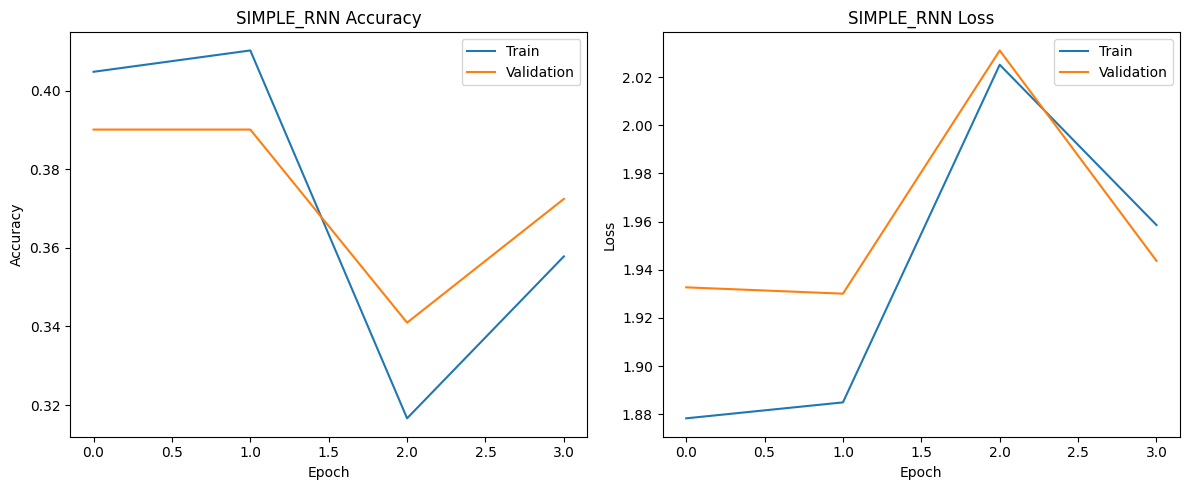

Test Accuracy: 41.52%


In [37]:
model_type='simple_rnn'
# Train model with explicit validation set
classifier.train(X_train, y_train, model_type=model_type, validation_data=val_ds,dataset="Dataset-1")
simple_rnn_acc=classifier.evaluate(test_texts=X_test, test_labels=y_test, model_type=model_type)
classifier.plot_history(model_type)
print(f"Test Accuracy: {simple_rnn_acc['accuracy']:.2%}")

### b) LSTM

Epoch 1/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.5556 - loss: 1.7059 - val_accuracy: 0.7358 - val_loss: 1.3702
Epoch 2/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.7631 - loss: 1.3105 - val_accuracy: 0.7515 - val_loss: 1.3135
Epoch 3/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.7843 - loss: 1.2189 - val_accuracy: 0.7554 - val_loss: 1.5076
Epoch 4/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.7866 - loss: 1.3301 - val_accuracy: 0.7120 - val_loss: 1.7983
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 366ms/step - accuracy: 0.7627 - loss: 1.2930


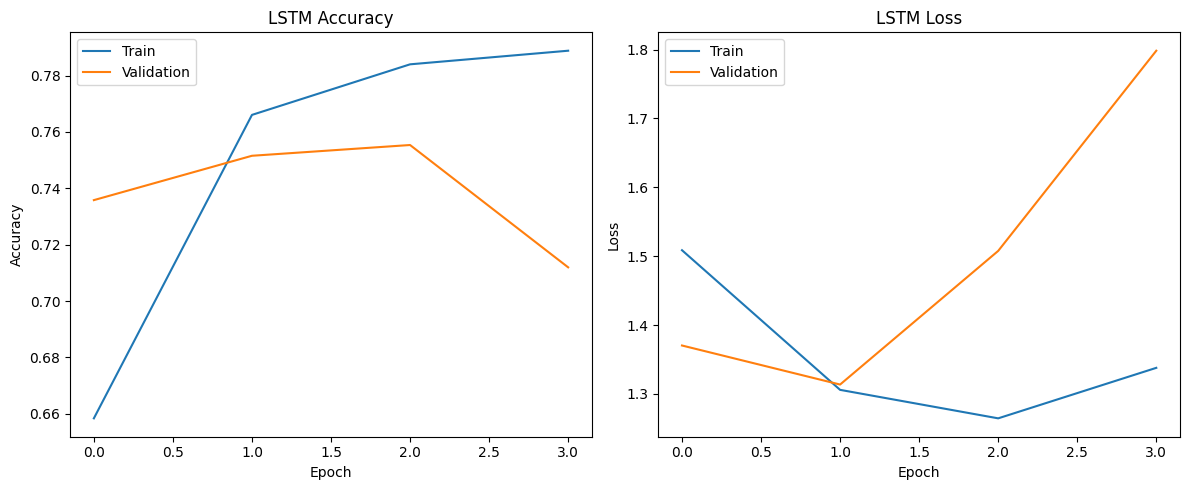

Test Accuracy: 76.84%


In [38]:
model_type='lstm'
# Train model with explicit validation set
classifier.train(X_train, y_train, model_type=model_type, validation_data=val_ds,dataset="Dataset-1")
lstm_acc=classifier.evaluate(test_texts=X_test, test_labels=y_test, model_type=model_type)
classifier.plot_history(model_type)
print(f"Test Accuracy: {lstm_acc['accuracy']:.2%}")

### c) GRU

Epoch 1/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.5669 - loss: 1.6919 - val_accuracy: 0.7678 - val_loss: 1.2985
Epoch 2/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.7898 - loss: 1.2004 - val_accuracy: 0.7639 - val_loss: 1.4243
Epoch 3/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.8006 - loss: 1.1920 - val_accuracy: 0.7582 - val_loss: 1.3985
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 354ms/step - accuracy: 0.7700 - loss: 1.2599


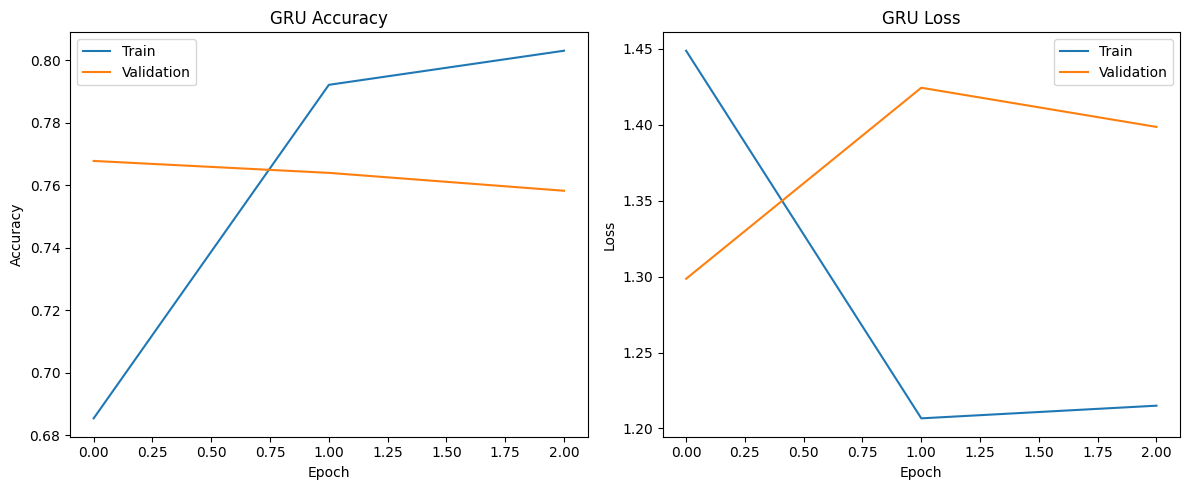

Test Accuracy: 77.36%


In [39]:
model_type='gru'
# Train model with explicit validation set
classifier.train(X_train, y_train, model_type=model_type, validation_data=val_ds,dataset="Dataset-1")
gru_acc=classifier.evaluate(test_texts=X_test, test_labels=y_test, model_type=model_type)
classifier.plot_history(model_type)
print(f"Test Accuracy: {gru_acc['accuracy']:.2%}")

### d) BILSTM

Epoch 1/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 251s 933ms/step - accuracy: 0.5982 - loss: 1.6520 - val_accuracy: 0.7501 - val_loss: 1.4388
Epoch 2/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 239s 910ms/step - accuracy: 0.7712 - loss: 1.2966 - val_accuracy: 0.7525 - val_loss: 1.4480
Epoch 3/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 230s 877ms/step - accuracy: 0.7871 - loss: 1.3391 - val_accuracy: 0.7349 - val_loss: 1.7926
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.7559 - loss: 1.3972


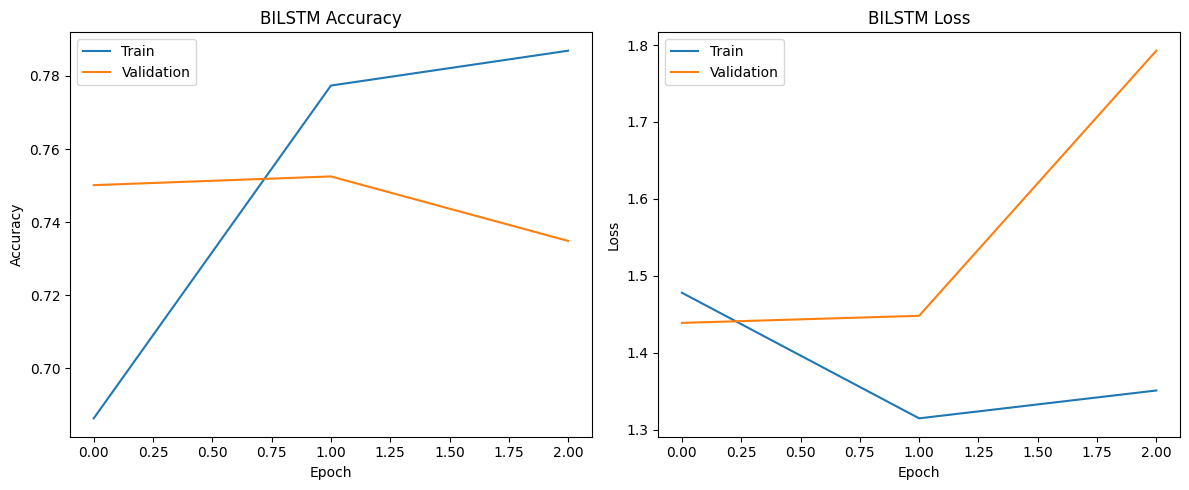

Test Accuracy: 75.69%


In [40]:
model_type='bilstm'
# Train model with explicit validation set
classifier.train(X_train, y_train, model_type=model_type, validation_data=val_ds,dataset="Dataset-1")
bilstm_acc=classifier.evaluate(test_texts=X_test, test_labels=y_test, model_type=model_type)
classifier.plot_history(model_type)
print(f"Test Accuracy: {bilstm_acc['accuracy']:.2%}")

## Specific funtion for Spliting the Dataset-2

**use the first 50% examples as training, next 20% for validation, and the next 30% for testing**

In [41]:
def split_dataset_domain_order(df):
    # Identify class columns
    class_cols = [col for col in df.columns if col != 'Content']
    
    # Initialize empty sets for indices
    train_indices = set()
    val_indices = set()
    test_indices = set()

    for cls in class_cols:
        # Get class examples in original order
        class_examples = df[df[cls] == 1].index.tolist()
        n = len(class_examples)
        
        # Calculate split points
        train_end = int(0.5 * n)
        val_end = train_end + int(0.2 * n)
        
        # Add to respective sets
        train_indices.update(class_examples[:train_end])
        val_indices.update(class_examples[train_end:val_end])
        test_indices.update(class_examples[val_end:])
    
    # Remove overlaps with priority: train > val > test
    val_indices = val_indices - train_indices
    test_indices = test_indices - train_indices - val_indices
    
    # Create splits preserving original order
    train_df = df.loc[sorted(train_indices)]
    val_df = df.loc[sorted(val_indices)]
    test_df = df.loc[sorted(test_indices)]
    
    return train_df, val_df, test_df

# Spliting Dataset and Creating model for Dataset-2

In [42]:
# Split Dataset 2 using domain-order splitting
train_df, val_df, test_df = split_dataset_domain_order(data2_copy)

# Initialize classifier with Dataset 2's class names
classifier = TextClassifier(
    class_names=train_df.columns[train_df.columns != 'Content'],  # Auto-detect classes
    vocab_size=30000,
    max_seq_length=500
)

# Preprocess splits while preserving domain order
def preprocess_split(df):
    """Helper to maintain DataFrame structure during preprocessing"""
    return classifier.preprocess_data(df, text_columns=['Content'])

train_texts, train_labels = preprocess_split(train_df)
val_texts, val_labels = preprocess_split(val_df)
test_texts, test_labels = preprocess_split(test_df)

# Adapt vectorizer ONLY on training data
classifier.adapt_vectorizer(train_texts)

# Create TensorFlow datasets with domain-ordered splits
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_texts, train_labels.astype('float32'))
).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_texts, val_labels.astype('float32'))
).batch(64)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_texts, test_labels.astype('float32'))
).batch(64)

### a)Simple RNN

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 410ms/step - accuracy: 0.3279 - loss: 1.5210 - val_accuracy: 0.4968 - val_loss: 1.2529
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.8988 - loss: 0.5378 - val_accuracy: 0.5083 - val_loss: 1.2549
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9979 - loss: 0.0485 - val_accuracy: 0.5977 - val_loss: 1.0571
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 0.5594 - val_loss: 1.1478
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.5645 - val_loss: 1.1478
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.6045 - loss: 1.1215


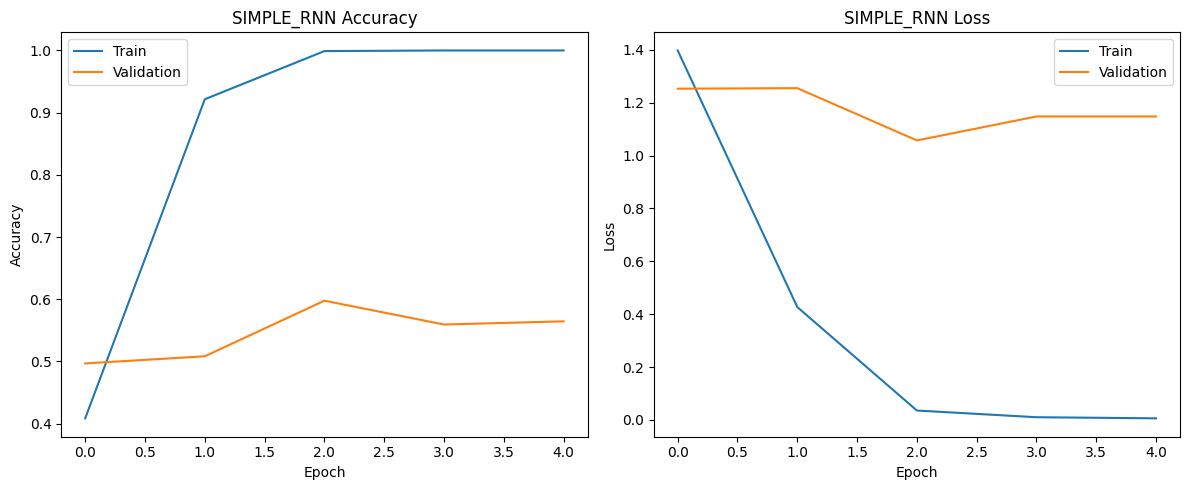

Test Accuracy: 60.71%


In [43]:
model_type='simple_rnn'
# Train with domain-ordered validation
classifier.train(train_texts, train_labels,model_type=model_type,validation_data=val_ds,dataset="Dataset-2")

# Evaluate on domain-ordered test set
data2_simple_rnn_acc = classifier.evaluate(test_texts, test_labels, model_type=model_type)
classifier.plot_history(model_type)
print(f"Test Accuracy: {data2_simple_rnn_acc['accuracy']:.2%}")

### b) LSTM

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 980ms/step - accuracy: 0.5049 - loss: 1.3013 - val_accuracy: 0.7739 - val_loss: 0.5562
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 960ms/step - accuracy: 0.8103 - loss: 0.6015 - val_accuracy: 0.7407 - val_loss: 0.6518
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 995ms/step - accuracy: 0.8192 - loss: 0.5213 - val_accuracy: 0.9285 - val_loss: 0.2716
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 958ms/step - accuracy: 0.9587 - loss: 0.1718 - val_accuracy: 0.9310 - val_loss: 0.2667
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 958ms/step - accuracy: 0.9713 - loss: 0.1184 - val_accuracy: 0.9208 - val_loss: 0.2775
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 955ms/step - accuracy: 0.9421 - loss: 0.1576 - val_accuracy: 0.9132 - val_loss: 0.2843
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.9453 - loss: 0.2352


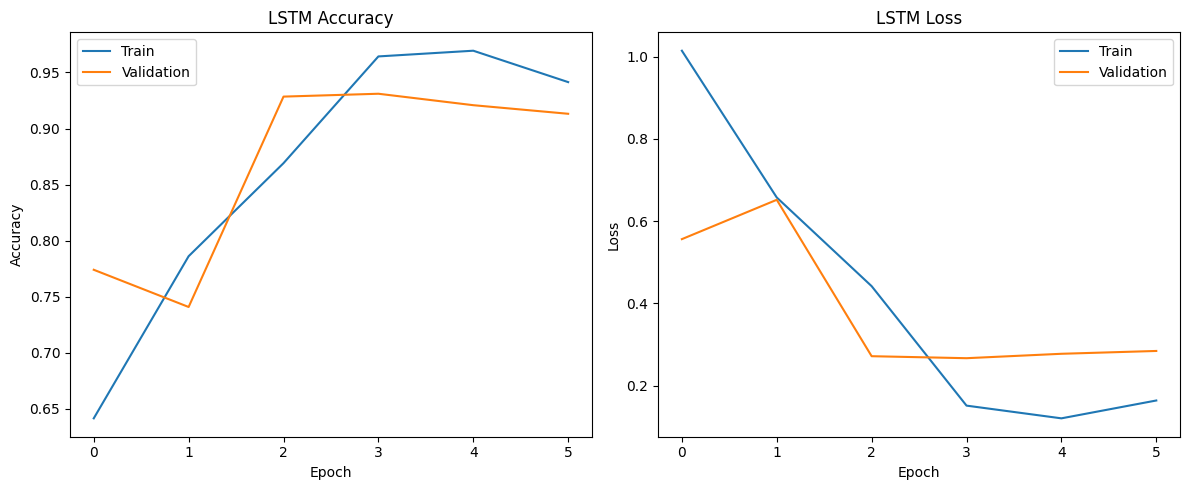

Test Accuracy: 94.24%


In [44]:
model_type='lstm'
# Train with domain-ordered validation
classifier.train(train_texts, train_labels,model_type=model_type,validation_data=val_ds,dataset="Dataset-2")

# Evaluate on domain-ordered test set
data2_lstm_acc = classifier.evaluate(test_texts, test_labels, model_type=model_type)
classifier.plot_history(model_type)
print(f"Test Accuracy: {data2_lstm_acc['accuracy']:.2%}")

### c) GRU

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 927ms/step - accuracy: 0.4681 - loss: 1.4261 - val_accuracy: 0.7267 - val_loss: 0.7283
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 915ms/step - accuracy: 0.7901 - loss: 0.4610 - val_accuracy: 0.8697 - val_loss: 0.4241
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 924ms/step - accuracy: 0.9819 - loss: 0.1135 - val_accuracy: 0.9336 - val_loss: 0.1926
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 893ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 0.9336 - val_loss: 0.2169
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 927ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9400 - val_loss: 0.1912
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 915ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9438 - val_loss: 0.1835
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 928ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9515 - val_loss: 0.1826
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 925ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accu

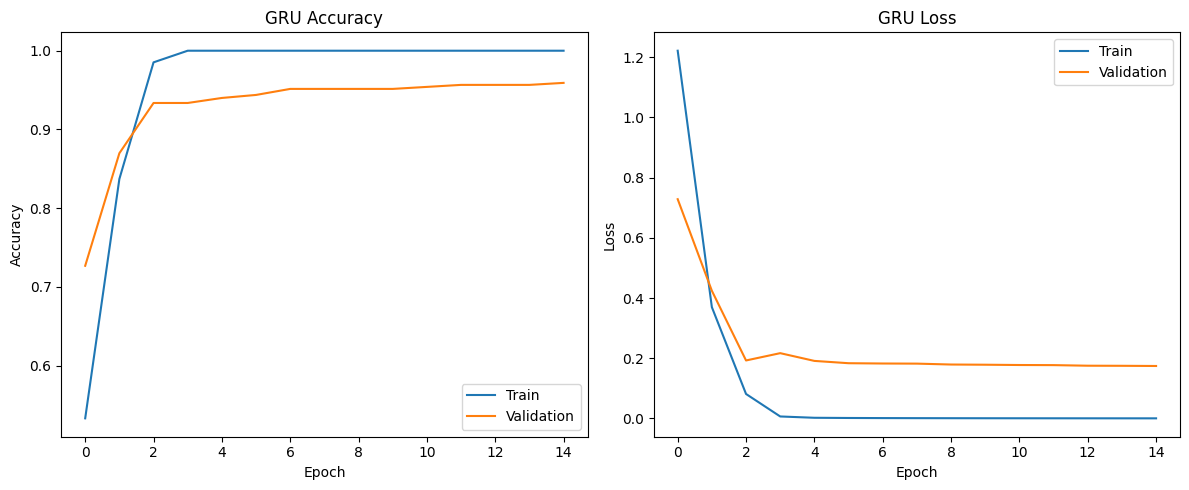

Test Accuracy: 94.83%


In [45]:
model_type='gru'
# Train with domain-ordered validation
classifier.train(train_texts, train_labels,model_type=model_type,validation_data=val_ds,dataset="Dataset-2")

# Evaluate on domain-ordered test set
data2_gru_acc = classifier.evaluate(test_texts, test_labels, model_type=model_type)
classifier.plot_history(model_type)
print(f"Test Accuracy: {data2_gru_acc['accuracy']:.2%}")

### d) BILSTM

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5173 - loss: 1.3181 - val_accuracy: 0.9655 - val_loss: 0.2897
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1000ms/step - accuracy: 0.9809 - loss: 0.1893 - val_accuracy: 0.9693 - val_loss: 0.1019
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9969 - loss: 0.0367 - val_accuracy: 0.9962 - val_loss: 0.0265
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.9987 - val_loss: 0.0163
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 981ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9987 - val_loss: 0.0126
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9987 - val_loss: 0.0120
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9987 - val_loss: 0.0115
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9987 - va

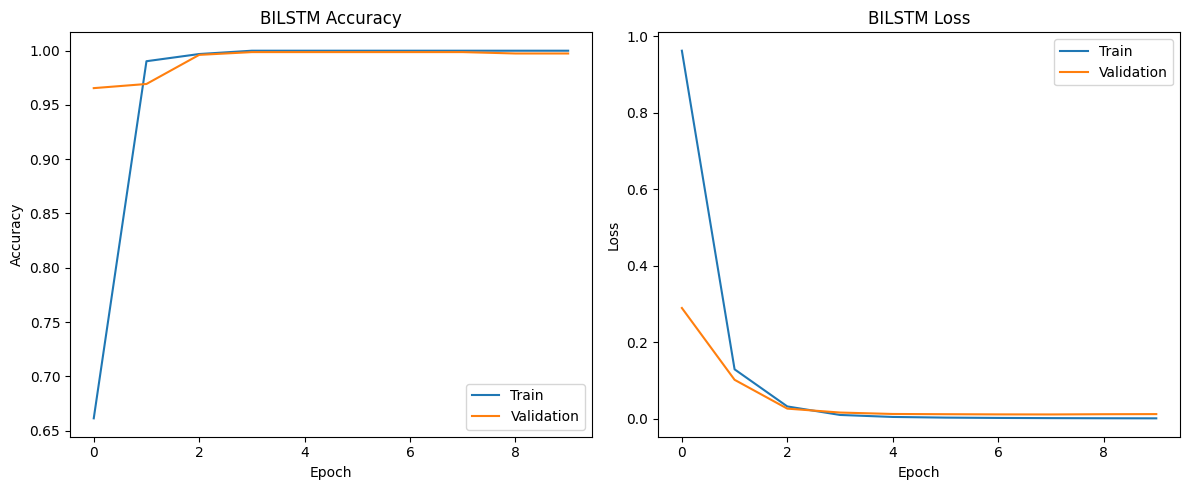

Test Accuracy: 99.75%


In [46]:
model_type='bilstm'
# Train with domain-ordered validation
classifier.train(train_texts, train_labels,model_type=model_type,validation_data=val_ds,dataset="Dataset-2")

# Evaluate on domain-ordered test set
data2_bilstm_acc = classifier.evaluate(test_texts, test_labels, model_type=model_type)
classifier.plot_history(model_type)
print(f"Test Accuracy: {data2_bilstm_acc['accuracy']:.2%}")

# Plotting function (use Plotly)

In [48]:
def plot_rnn_comparisons(simple_rnn, lstm, gru, bilstm):
    # Convert data to DataFrame for easier plotting
    df = pd.DataFrame({
        'Model': ['Simple RNN', 'LSTM', 'GRU', 'BiLSTM'],
        'Accuracy': [simple_rnn['accuracy'], lstm['accuracy'], gru['accuracy'], bilstm['accuracy']],
        'Loss': [simple_rnn['loss'], lstm['loss'], gru['loss'], bilstm['loss']]
    })
    
    # Create subplots with 1 row and 2 columns
    fig = make_subplots(
        rows=1, cols=2, 
        subplot_titles=("Model Accuracy Comparison", "Model Loss Comparison"),
        specs=[[{"type": "bar"}, {"type": "bar"}]]
    )
    
    # Define custom colors for better visualization
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']
    
    # Add accuracy trace
    fig.add_trace(
        go.Bar(
            x=df['Model'],
            y=df['Accuracy'],
            name='Accuracy',
            marker_color=colors,
            text=df['Accuracy'].round(4),
            textposition='auto',
            hovertemplate='<b>%{x}</b><br>Accuracy: %{y:.4f}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add loss trace
    fig.add_trace(
        go.Bar(
            x=df['Model'],
            y=df['Loss'],
            name='Loss',
            marker_color=colors,
            text=df['Loss'].round(4),
            textposition='auto',
            hovertemplate='<b>%{x}</b><br>Loss: %{y:.4f}<extra></extra>'
        ),
        row=1, col=2
    )
    
    # Update layout
    fig.update_layout(
        title_text="RNN Architecture Performance Comparison",
        height=500,
        width=1000,
        template="plotly_dark",
        showlegend=False,
        font=dict(family="Arial, sans-serif", size=12),
    )
    
    # Update y-axes
    fig.update_yaxes(title_text="Accuracy", range=[0, 1.1*max(df['Accuracy'])], row=1, col=1)
    fig.update_yaxes(title_text="Loss", range=[0, 1.1*max(df['Loss'])], row=1, col=2)
    
    # Show plot
    fig.show()

## Dataset-1 Test evaluation Graph

In [49]:
plot_rnn_comparisons(simple_rnn_acc, lstm_acc, gru_acc, bilstm_acc)

## Dataset-2 Test evaluation Graph

In [50]:
plot_rnn_comparisons(data2_simple_rnn_acc, data2_lstm_acc, data2_gru_acc, data2_bilstm_acc)